# Statistical significance

## Introduction

In the world of biostatistics, we often face a crucial question: does the data we've gathered reveal a _true effect_, or is it simply the result of _random chance_? The concept of **statistical significance** offers a framework to grapple with this uncertainty, providing a tool to help us discern _meaningful_ patterns from the _noise_ inherent in biological systems. This chapter delves into the core of statistical significance, exploring why it matters, when it's most useful, and how it can be a valuable guide in drawing conclusions from the data. Importantly, we'll also discuss the potential pitfalls of relying too heavily on this concept, as well as when alternative approaches might be more appropriate.

## The reproducibility challenge

### Variability of P values under a true effect

P values, a cornerstone of statistical significance testing, can often give the illusion of definitive answers. However, they are inherently sensitive to the specific data set at hand, leading to a reproducibility challenge. To illustrate this, let's consider a Python simulation:

In [1]:
import numpy as np
from scipy.stats import ttest_ind

# For reproducibility
np.random.seed(111)

# Parameters
sample_size = 10
population_std_dev = 5.0
mean_difference = 5.0
num_simulations = 1000

# Store P values
p_values = []

# Run simulations
for _ in range(num_simulations):
    # Sample from two populations with different means
    data1 = np.random.normal(0, population_std_dev, sample_size)
    data2 = np.random.normal(mean_difference, population_std_dev, sample_size)
    
    # Perform t-test
    _, p_value = ttest_ind(data1, data2)
    p_values.append(p_value)

# Analyze P values
print("Proportion of P values < 0.05:", np.mean(np.array(p_values) < 0.05))

Proportion of P values < 0.05: 0.592


This code repeatedly samples 10 data points from two Gaussian distributions with the same standard deviation (5.0) but a mean difference of 5.0, so under a _true effect_. Each time, it performs a **t-test** to compare the means and records the resulting P value.

What we often find is a surprising inconsistency. Even though the underlying populations have a true difference in means, the proportion of P values considered "statistically significant" (typically $\alpha \lt 0.05$) fluctuates significantly across simulations. This highlights the inherent variability of P values and the potential for misleading conclusions when a single analysis is treated as definitive.

The 2.5th and 97.5th percentiles are [1.69152124e-04 7.02604441e-01]


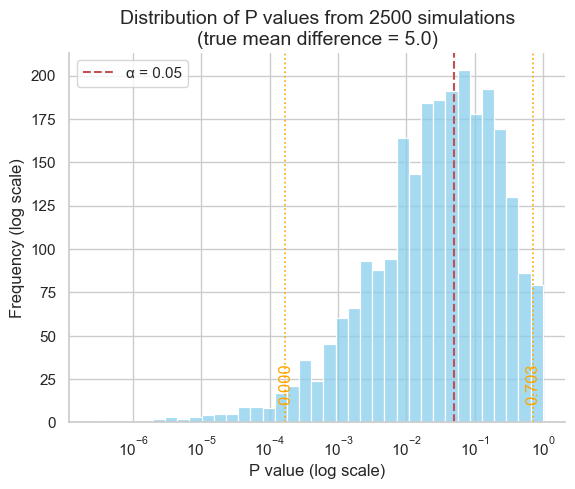

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(111)

# Simulation parameters
N = 10      # Sample size per group
SD = 5.0    # Standard deviation
mean = 0    # Mean of the first population
num_simulations = 2500

# Store P values
p_values = []

# Run simulations
for _ in range(num_simulations):
    pop_1 = np.random.normal(loc=mean, scale=SD, size=N)
    pop_2 = np.random.normal(loc=mean + 5, scale=SD, size=N)  
    _, p_value = ttest_ind(pop_1, pop_2)
    p_values.append(p_value)

# Calculate percentiles
percentiles = np.percentile(p_values, [2.5, 97.5])  # Get 2.5% and 97.5% percentiles
print(f"The 2.5th and 97.5th percentiles are {percentiles}")

# Plotting
sns.set_theme(style="whitegrid") # Optional: set a clean seaborn style
# plt.figure(figsize=(10, 6))
# Histogram with log scale
sns.histplot(p_values, kde=False, log_scale=True, color="skyblue")
# Vertical line at p=0.05
plt.axvline(0.05, color='r', linestyle='dashed', linewidth=1.5, label="α = 0.05")

# Add percentile lines and annotations
for p in percentiles:
    plt.axvline(p, color='orange', linestyle='dotted', linewidth=1.2)
    plt.text(p, 10, f"{p:.3f}", color='orange', rotation=90, va='bottom', ha='center')

plt.xlabel("P value (log scale)", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title(
    "Distribution of P values from 2500 simulations\n(true mean difference = 5.0)",
    fontsize=14)
plt.legend()
sns.despine();

As our simulation demonstrates, the middle 95% of P values can span a vast range, from as low as 0.000169 to as high as 0.7026 - a difference of over three orders of magnitude! This immense variability underscores a crucial point: P values are far less reproducible than most researchers anticipate.

This lack of reproducibility has significant implications for the conclusions we draw about statistical significance. Consider a study that finds a P value of exactly 0.05, barely crossing the threshold for significance. If this study were repeated, there's only a 50% chance that the new P value would also be below 0.05, as revealed by simulations:

| Initial P value | Probability of P value < 0.05 in replication |
|:--------------- |:-------------------------------------------- |
| 0.10            | 38 %                                         |
| 0.05            | 50 %                                         |
| 0.01            | 73 %                                         |
| 0.001           | 91 %                                         |
| 0.00031         | 95 %                                         |

In other words, even a seemingly "significant" finding is surprisingly susceptible to being overturned by chance in subsequent experiments.

This phenomenon isn't limited to borderline cases. Even with a highly "significant" initial P value of 0.001, there's no guarantee that a repeat study will yield a P value below the traditional 0.05 threshold. This highlights a fundamental truth: statistical significance, as determined by P values, is not a static property of a phenomenon but rather a probabilistic outcome dependent on the specific data at hand.

### The risk of false positives under the null hypothesis

While the variability of P values under a true effect is a concern, an even more insidious issue arises when there is no real effect to be found. In this scenario, the _null hypothesis is true_, yet random sampling can still lead to statistically significant results. This simulation explores the frequency of such false positives and their implications for drawing reliable conclusions.

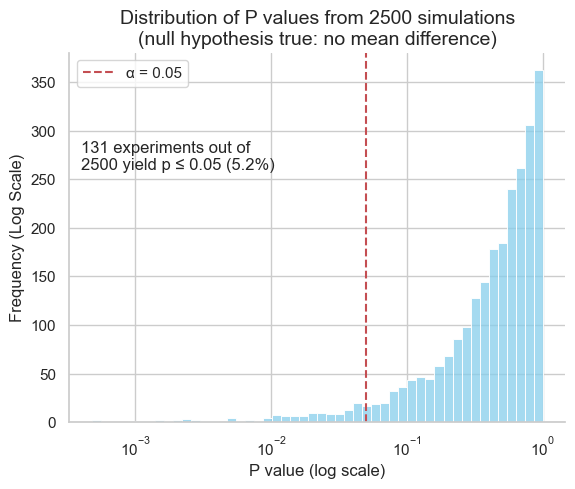

In [9]:
# Simulation parameters
N = 10      # Sample size per group
SD = 5.0    # Common standard deviation
mean = 10   # Common mean for both populations
num_simulations = 2500

# For reproducibility
np.random.seed(111)

# Store P values
p_values = []

# Run simulations
for _ in range(num_simulations):
    pop_1 = np.random.normal(loc=mean, scale=SD, size=N)
    # Same mean and SD for both populations, same sample size
    pop_2 = np.random.normal(loc=mean, scale=SD, size=N)
    _, p_value = ttest_ind(pop_1, pop_2)
    p_values.append(p_value)

# Calculate significance proportion
signif_proportion = np.mean(np.array(p_values) <= 0.05)

# Plotting
sns.set_theme(style="whitegrid")
# plt.figure(figsize=(10, 6))
sns.histplot(p_values, kde=False, log_scale=True, color="skyblue")
plt.axvline(
    0.05,
    color='r', linestyle='dashed', linewidth=1.5,
    label="α = 0.05")
plt.xlabel("P value (log scale)", fontsize=12)
plt.ylabel("Frequency (Log Scale)", fontsize=12)
plt.title(
    "Distribution of P values from 2500 simulations\n\
(null hypothesis true: no mean difference)",
    fontsize=14)
plt.text(
    0.0004, 290,
    f"{int(signif_proportion * num_simulations)} experiments out of \n\
{num_simulations} yield p ≤ 0.05 ({signif_proportion:.1%})", 
    fontsize=12, ha="left", va="top") 
plt.legend()
sns.despine();

In our simulation, where both populations had the same mean, approximately 5% of the experiments yielded P values below the 0.05 significance threshold. This phenomenon is known as a **type I error**, or a **false positive**. This aligns with the chosen significance level, highlighting that statistical significance does not guarantee a true effect. 

This underscores the importance of interpreting P values cautiously and considering them within the broader context of the research question, effect size, and potential for replication.

### Influence of sample size

The size of the sample (the number of observations in each group) plays a crucial role in determining the outcome of a statistical test. Even with the same underlying effect size and variability, a larger sample size can drastically alter the resulting P value. Let's illustrate this with a simulation using the t-distribution's cumulative distribution function (CDF). Here the number of degrees of freedom equals $n_1 + n_2 - 2$ which, with $n_1 = n_2 = n$, equals $2 \times n - 2$.

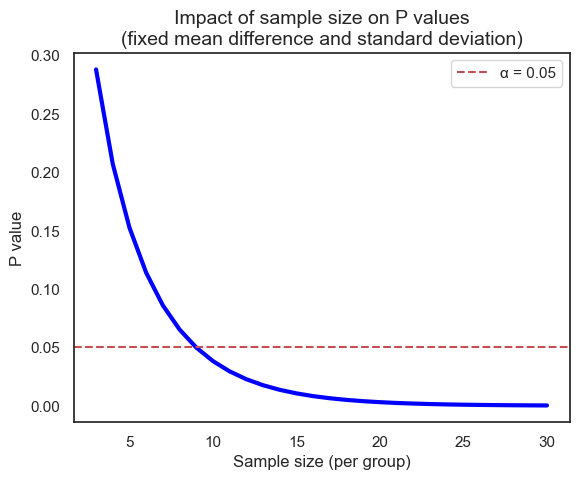

In [10]:
from scipy.stats import t

# Simulation parameters
mean1, mean2 = 10, 15    # Group means (fixed difference)
mean_diff = mean2 - mean1
SD = 5                   # Standard deviation (fixed)

p_values = []

for n in range(3, 31):   # Varying sample sizes
    # Calculate t-statistic (see previous chapter)
    t_stat = mean_diff / (SD * (2 / n)**0.5)
    p_value = 2 * (1 - t.cdf(x=abs(t_stat), df=2*n-2))  # Two-tailed P value
    p_values.append(p_value)

# Plotting
sns.set_theme(style="white")
# plt.figure(figsize=(10, 6))
sns.lineplot(x=list(range(3, 31)), y=p_values, lw=3, color="blue")
plt.xlabel("Sample size (per group)", fontsize=12)
plt.ylabel("P value", fontsize=12)
plt.title(
    "Impact of sample size on P values\n\
(fixed mean difference and standard deviation)",
    fontsize=14)
plt.axhline(
    0.05,
    color='r', linestyle='dashed', linewidth=1.5,
    label="α = 0.05")
plt.legend();

Of course, we can achieve the same results using both `scipy.stats.ttest_ind` (for the t-test) and directly working with the t-distribution, because the t-test relies on the t-distribution to model the behavior of the test statistic under the null hypothesis (will be discussed in later chapter).

In [5]:
# Sample data (two groups)
data1 = [8, 11, 12, 9, 14]
data2 = [15, 18, 17, 16, 20]

# Method 1: Using scipy.stats.ttest_ind
t_stat, p_value_ttest = ttest_ind(data1, data2)

# Method 2: Calculating directly from t-distribution
n1, n2 = len(data1), len(data2)                # Sample sizes
df = n1 + n2 - 2                               # Degrees of freedom
mean1, mean2 = np.mean(data1), np.mean(data2)  # Sample means
pooled_std = np.sqrt(
    (   # Pooled standard deviation
        (n1 - 1) * np.var(data1, ddof=1) + (n2 - 1) * np.var(data2, ddof=1)
    ) / df
)
t_stat_manual = (mean1 - mean2) / (pooled_std * np.sqrt(1/n1 + 1/n2))

# Calculate P value using t-distribution CDF
p_value_manual = 2 * (1 - t.cdf(abs(t_stat_manual), df=df)) 

print("Results using ttest_ind:")
print(f"t-statistic: {t_stat:.4f}, P value: {p_value_ttest:.4f}")

print("\nResults using manual calculation:")
print(f"t-statistic: {t_stat_manual:.4f}, P value: {p_value_manual:.4f}")

Results using ttest_ind:
t-statistic: -4.6677, P value: 0.0016

Results using manual calculation:
t-statistic: -4.6677, P value: 0.0016


### The danger of ad hoc sample size decisions

In research, it's tempting to collect data _incrementally_ and assess statistical significance after each addition. However, this **ad hoc** approach to sample size can lead to misleading conclusions. Let's simulate how **cumulative P values** behave under the null hypothesis, where there's no true difference between groups.

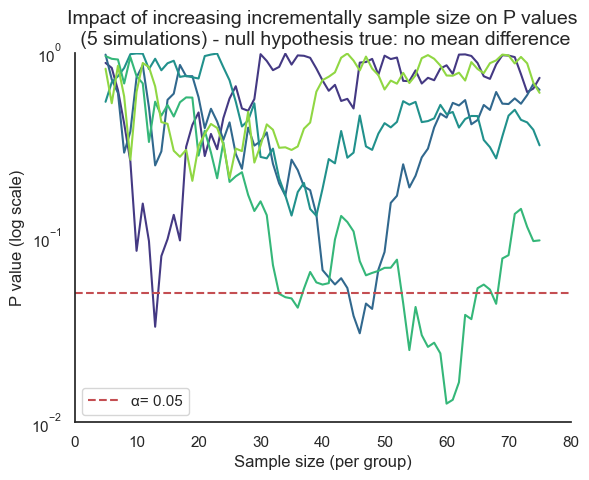

In [11]:
# Simulation parameters
sample_size_max = 75
num_simulations = 5
common_mean = 0
common_std_dev = 1.0

# Seaborn color palette
palette = sns.color_palette("viridis", n_colors=num_simulations)

# For reproducibility
np.random.seed(111)

# Plotting setup
# plt.figure(figsize=(10, 6))
sns.set_theme(style="white")

# Run simulations and plot
for sim_num in range(num_simulations):
    # Generate data for two populations with the same mean and SD
    pop_1 = np.random.normal(
        loc=common_mean, scale=common_std_dev, size=sample_size_max)
    pop_2 = np.random.normal(
        loc=common_mean, scale=common_std_dev, size=sample_size_max)

    p_values = []
    sample_sizes = list(range(5, sample_size_max + 1))

    # Iterate over increasing sample sizes
    for n in sample_sizes:
        _, p_value = ttest_ind(pop_1[:n], pop_2[:n])
        p_values.append(p_value)

    # Plot for this simulation using the Seaborn palette
    sns.lineplot(
        x=sample_sizes, y=p_values,
        # marker='o',
        color=palette[sim_num],
        # alpha=0.7, 
        # label=f"Simulation {sim_num + 1}",
    )

# Add labels and title
plt.axhline(
    0.05,
    color='r', linestyle='dashed', linewidth=1.5,
    label='α= 0.05')
plt.xlabel("Sample size (per group)", fontsize=12)
plt.ylabel("P value (log scale)", fontsize=12)
plt.title(
    f"Impact of increasing incrementally sample size on P values\n \
({num_simulations} simulations) - null hypothesis true: no mean difference",
    fontsize=14)
plt.yscale('log')
plt.ylim((0.01, 1))
plt.xlim((0, sample_size_max + 5))
# plt.grid(axis='y', linestyle='--')
plt.legend()
sns.despine();

Consider the potentially misleading practice of collecting data until a statistically significant result is achieved, then abruptly stopping the experiment. This approach capitalizes on the inherent randomness of sampling. If data collection were to continue beyond the initial "significant" finding, the P value might fluctuate back into the non-significant range as new data points are added.

This is evident with the first line in our previous simulation (where the curve rises between 13 and 14). However, for other samples, the rise of the P value back into non-significance could occur later or even never happen, leaving a false sense of confidence in the results. In real-world research, this fluctuation would often remain hidden due to the premature halt of data collection.

This dynamic adjustment of sample size, known as **sequential data analysis**, introduces **bias** and inflates the rate of **false positives** (**type I errors**). It's a statistical illusion, creating the misleading impression of a significant effect where none truly exists.

## Confidence intervals and P values

Confidence intervals offer a valuable alternative to P values for assessing statistical significance. They provide a _range of plausible values for the true population parameter_ (e.g., mean difference, effect size) with a specified level of confidence (typically 95%). Unlike P values, which focus solely on rejecting or failing to reject a null hypothesis, confidence intervals offer a more informative picture of the magnitude and uncertainty of an effect.

There's a direct relationship between confidence intervals and P values, particularly for two-sided tests:

- **95% CI excludes the null value**: if the 95% confidence interval for a parameter (e.g., mean difference) does not include the null hypothesis value (often 0 for differences or 1 for ratios), then the corresponding P value will be less than 0.05, indicating a **statistically significant** result.
- **95% CI includes the null value**: conversely, if the 95% confidence interval does contain the null hypothesis value, the P value will be greater than or equal to 0.05, suggesting that the results are **not statistically significant**. For example:
  - Comparing means: if the 95% CI for the difference between two means does not include zero, we can conclude a statistically significant difference exists between the groups (P < 0.05).
  - Comparing proportions: if the 95% CI for the ratio of two proportions does not include 1.0, we can conclude a statistically significant difference exists (P < 0.05).
  - Comparing percentages: if we're testing whether a set of percentages differs from a hypothesized value of 100, and the 95% CI of the mean of the percentages excludes 100, then the discrepancy is statistically significant.

Confidence intervals offer several advantages over P values alone:

- Effect size estimation: CIs provide an estimate of the magnitude of the effect, not just whether it's statistically significant.
- Precision assessment: the width of the CI reflects the precision of the estimate. Narrower CIs indicate more precise estimates.
- Decision relevance: CIs help assess the practical significance of the effect by showing the range of plausible values.

In biostatistics and many other fields, it's increasingly recommended to report confidence intervals alongside P values. This provides a more comprehensive and informative view of our findings, allowing for better decision-making based on both statistical significance and the estimated magnitude of the effect.

## Statistical significance and hypothesis testing

Statistical hypothesis testing offers a standardized framework for drawing conclusions from data. At its core, this approach streamlines the complex process of interpreting results by distilling findings into a **binary outcome**: *statistically significant* or *not statistically significant*. This automation of decision-making can be both a strength and a weakness. In this section, we'll delve deeper into the principles of hypothesis testing, exploring how it simplifies decision-making, the criteria it relies upon, and the potential pitfalls that arise from oversimplification. We'll also discuss when and how hypothesis testing can be a valuable tool in the biostatistical arsenal.

### Type I and type II errors

The binary nature of statistical hypothesis testing (reject H0 or do not reject H0) creates a landscape of potential errors, as our decisions are made under uncertainty. These errors are classified into two distinct types, each with its own consequences:

|             | Reject H0    | Do not reject H0 |
| ----------- | ------------ | ---------------- |
| H0 is true  | type I error | (no error)       |
| H0 is false | (no error)   | type II error    |

- **Type I error** (**false positive**): this occurs when we reject the null hypothesis (H0) even though it's actually true. In other words, we conclude there's a significant effect when, in reality, it's due to chance. Think of this as a "false alarm". In everyday life, we might mistakenly flag a legitimate email as spam or, more seriously, wrongly convict someone of a crime they didn't commit.

- **Type II error** (**false negative**): this happens when we fail to reject the null hypothesis (H0) when it's actually false. This means we miss a real effect and incorrectly conclude there's no significant difference. Consider this a "missed opportunity." In everyday life, we might mistakenly let a spam email slip into our inbox or, more seriously, wrongly acquit someone who actually committed a crime.

A third type of error, known as a **type S** or **type III error**, occurs when the direction of the effect is incorrectly concluded. In other words, we might find a statistically significant difference, but the direction of that difference is the _opposite_ of what is actually true. Imagine a study that aims to determine if a new drug lowers blood pressure. A type S error would occur if the study concludes that the drug raises blood pressure when it actually lowers it, even though the statistical test shows a significant difference.

### Interpreting statistical significance

#### The significance level

When a statistical test yields a "significant" result, it means the observed effect is unlikely to have occurred by chance alone, given a pre-specified threshold of improbability. This threshold is known as the significance level, denoted by the Greek letter alpha (α).

Typically, researchers set alpha at 0.05, meaning there's a 5% chance of incorrectly rejecting the null hypothesis (H0) when it's actually true (a type I error). A P value less than alpha leads to rejecting H0, while a P value greater than or equal to alpha leads to failing to reject H0.

While a significant result (P < α) suggests an effect is unlikely due to chance, it doesn't guarantee the effect is:

- Large: a small effect can be statistically significant with a large enough sample size.
- Important: statistical significance doesn't equate to practical or clinical significance.
- Accurate: a significant result could still be a type I error.

Now, we can ask ourselves:

- Assuming the null hypothesis is true, what is the probability of obtaining a P value that would lead us to incorrectly reject the null hypothesis?
- If we repeatedly conduct experiments where there is no true effect, what proportion of these experiments will mistakenly lead us to conclude that there is a significant effect?

In practical terms, α can also be understood through repeated experimentation. Imagine conducting numerous experiments where the null hypothesis (H0) is true. Let $A$ represent the number of times we incorrectly reject H0 (type I errors), and let $B$ represent the number of times we correctly fail to reject H0:

|             |  Reject H0  | Do not reject H0 |  Total  |
| ----------- |:-----------:|:----------------:|:-------:|
| H0 is true  |  A (type I) |        B         |  A + B  |
| H0 is false |      C      |   D (type II)    |  C + D  |
| Total       |    A + C    |      B + D       | A+B+C+D |


The significance level only considers analyses where _H0 is true_ (first row of the table). Of all experiments (A+B), the number of times H0 is rejected equals A, so that:

$$\alpha = \frac{A}{A+B}$$

In other words, α is the proportion of experiments where we mistakenly reject H0 when it's actually true. This highlights a key point: even when there is no real effect, a certain percentage of studies will yield statistically significant results simply due to random chance.

#### False positive report probability (FPRP)

While α focuses on the risk of a type I error within a single experiment, the **false positive report probability (FPRP)** takes a broader perspective. It considers the probability that a statistically significant finding in a research report actually represents a false positive result.

The FPRP acknowledges that research doesn't exist in isolation. In practice, multiple studies are often conducted to investigate a particular phenomenon. Some of these studies might yield significant results by chance (type I errors). The FPRP asks: given a significant finding in a published report, what's the probability that this result is actually a false positive?

The FPRP only considers analyses that **reject H0** (first column of the table). Of all these studies that report a statistically significant result (reject H0) A+C, and with C the number of studies that report a significant result and where H0 is truly false (true positive), the number in which H0 is true equals A, therefore:

$$\text{FPRP} = \frac{A}{A+C}$$

In other words, the FPRP is the proportion of significant results that are actually false positives.

### Prior probability influences FPRP

The FPRP isn't a fixed value; it varies depending on several factors, including the significance level (α) and statistical power of the study. However, an often overlooked but critical factor is the **prior probability** of a true effect. This reflects our _existing knowledge_ or _belief_ about the likelihood of the phenomenon under investigation before we even conduct the experiment.

Intuitively, if we're testing a hypothesis that seems highly implausible based on prior research or scientific understanding, even a statistically significant result should be met with greater skepticism. In contrast, a significant finding for a well-established phenomenon is more likely to be a true positive.

The table below illustrates how the FPRP changes depending on the prior probability of a true effect, assuming a fixed significance level and power.

| Prior probability | FPRP as P<0.05 | FPRP as 0.045<P<0.05 |
| ----------------- | -------------- | -------------------- |
|         0%        |      100%      |         100%         |
|         1%        |       86%      |          97%         |
|        10%        |       36%      |          78%         |
|        50%        |      5.9%      |          27%         |
|       100%        |        0%      |           0%         |

Let's explore these scenarios to understand the nuanced relationship between FPRP and the broader scientific context.

#### Prior probability of 1%

Consider a scenario where we're testing 1,000 new drug compounds, but prior research indicates that the probability of any single drug being successful is a mere 1%. What can we expect in terms of both true and false positive findings?

_We need to consider not just the risk of false positives, but also the chance of missing a truly effective drug (a false negative). This is where the concept of **power** comes in. We will discuss it in more details in another section, but briefly, power is the probability that our experiment will correctly identify a truly effective drug as significant. In this case, with a 1% prior probability, a high-powered study is crucial. If our study has low power, we might miss out on most of the effective drugs, even if they exist._

- Of 1000 drugs screened we expect 10 (1%) that really work
- Of the 10 drugs that really work we expect to obtain a statistically significant result in 8 (80 % power)
- Of the 990 drugs that are really ineffective we expect to obtain a statistically significant result in 5% (α set to 0.05), i.e. 0.05 * 990 = 49 false positive
- Of 1000 tests of different drugs we therefore expect to obtain statistically significant difference in 8+49=57
- The FPRP equals 49/57=86%

```markdown
            8 have P<0.05 (80% power)
           /
       10 work (prior probability=50%)
      /    \
     /      2 have P>0.05
1000 drugs
     \          49 have P<0.05 (5% significance level)
      \        /
       990 don't work
               \
                941 have P>0.05
```

|                     | Statistically significant | Not significant | Total |
| ------------------- |:-------------------------:|:---------------:|:-----:|
| Drug is ineffective |              49           |       941       |  990  |
| Drug is effective   |               8           |        2        |   10  |
| Total               |              57           |       943       |  1000 |

With such a low prior probability of success (1%), conducting this experiment with a conventional significance level of 5% (α= 0.05) is likely to yield a high rate of false positives. This means that many of the drugs identified as 'significant' would actually be ineffective. To ensure the validity and usefulness of this drug screening, a much stricter significance level, such as 0.1% (α = 0.001), may be necessary. This stricter threshold would reduce the risk of falsely identifying ineffective drugs as promising candidates, but it would also increase the risk of missing truly effective drugs (type II errors). Balancing these risks requires careful consideration of the specific context, costs, and potential benefits of the drug screening program.

#### Prior probability of 50%

Even perfectly performed experiments are less reproducible than most expect, and many statistically significant results are false positives in situations where false positive results are likely, e.g. with low prior probability in observational studies or when multiple comparisons are made. In contrast, when the prior probability of a true effect is higher, such as 50%, the likelihood of a significant result being a true positive increases substantially, with here the FPRP equals 25/425 = 5.9%, even if the study is underpowered:

```markdown
             400 have P<0.05 (80% power)
            /
       500 work (prior probability=50%)
      /     \
     /       100 have P>0.05
1000 drugs
     \          25 have P<0.05 (5% significance level)
      \        /
       500 don't work
               \
                475 have P>0.05
```

|                     | Statistically significant | Not significant | Total |
| ------------------- |:-------------------------:|:---------------:|:-----:|
| Drug is ineffective |              25           |       475       |   500 |
| Drug is effective   |             400           |       100       |   500 |
| Total               |             425           |       943       |  1000 |

Furthermore, if an experiment has low power to find the difference/effect we are looking for, we are likely to end up with a result that is not statistically significant even if the effect is real. And if the low power study does reach a conclusion that the effect is statistically significant, the results are hard to interpret because the FPRP will be high, and the effect size observed in that study is likely to be larger than the actual effect size because only large observed effects (even if due to chance) will yield a P value less than 0.05. Experiments designed with low power cannot be very informative, and it should not be surprising when they cannot be reproduced.

## The challenge of multiple comparisons

When conducting multiple statistical tests within a study, the probability of encountering at least one false positive result increases significantly. This is known as the multiple comparisons problem.

Each statistical test carries an inherent risk of a type I error (false positive), and conducting multiple tests compounds this risk. Think of it like rolling the dice multiple times - the more you roll, the higher the chance of getting a "lucky" (but misleading) significant result.

The multiple comparisons problem can lead to false discoveries and unreliable conclusions. In this section, we'll explore the causes and consequences of this issue, and we'll introduce statistical methods to mitigate the inflated risk of false positives.

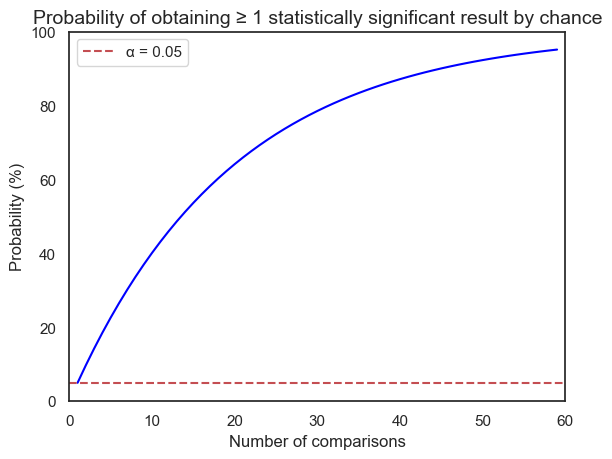

In [12]:
# Data
x = np.arange(1, 60)  # Number of comparisons (1 to 59)
y = 100 * (1 - 0.95**x)  # Probability of at least one significant result (%)

# Plot
# plt.figure(figsize=(10, 6))
sns.lineplot(x=x, y=y, color="blue")
plt.axhline(
    5,
    color='r', linestyle='dashed', linewidth=1.5,
    label="α = 0.05")  # Add alpha level line
plt.title(
    "Probability of obtaining ≥ 1 statistically significant result by chance",
    fontsize=14)
plt.xlabel("Number of comparisons", fontsize=12)
plt.ylabel("Probability (%)", fontsize=12)
plt.xlim(0, 60)
plt.ylim(0, 100)
plt.legend();

This plot illustrate the concept of the multiple comparisons problem. The x-axis represents the number of comparisons made in a study, while the y-axis shows the probability of obtaining at least one statistically significant result purely by chance.

As we can see, even with a single comparison (x=1) and an alpha level of 0.05, there's a 5% chance of getting a false positive. As the number of comparisons increases, this probability rapidly rises. For instance, with just 14 comparisons, the probability of at least one false positive exceeds 50%!

### Bonferroni correction

The simplest approach to controlling the familywise error rate (FWER) is the **Bonferroni correction**, which involves dividing the desired overall significance level ($\alpha$) by the number of comparisons $K$: $\alpha_\text{adjusted} = \alpha / K$. This adjustment ensures that if all the null hypotheses are true, the probability of observing at least one false positive (type I error) among all K comparisons is at most α.

The Bonferroni correction does not guarantee exactly a 95% chance of seeing no significant results if all null hypotheses are true. It provides a more conservative upper bound on this probability, making it less likely to make any false discoveries. However, this comes at the cost of reduced power to detect true effects (increased risk of type II errors).

### False discovery rate (FDR)

The **false discovery rate (FDR)** offers a more flexible alternative to the Bonferroni correction for addressing multiple comparisons. Instead of strictly controlling the probability of any false positives, the FDR aims to control the proportion of false positives among the discoveries we make. The FDR addresses these key questions:

- If a comparison is deemed significant (P value below a threshold), what's the chance it's actually a false positive (H0 is true)?
- Of all significant findings, what fraction are expected to be false positives?

The desired FDR, often denoted as Q, is the acceptable proportion of false discoveries. For example, with Q = 10%, we aim for at least 90% of our significant results to be true positives.

A widely used method to control the FDR is the **Benjamini-Hochberg** procedure. It sets dynamic thresholds for each comparison, depending on its rank among the P values. For example, if we want an FDR of 5% across 100 comparisons, we would:

1. Rank P values: order the P values from smallest to largest, i.e., $P(1), P(2), ..., P(100)$
2. Calculate Thresholds: for each P value $P(i)$, calculate a threshold $T(i)$ using this formula $T(i) = (i / m) \times Q$, with $i$ the rank of the P value, i.e., $1, 2, ..., 100$, and $m$ the total number of comparisons, i.e., $100$
3. Compare and Decide: if $P(i) \leq T(i)$, declare the comparison as significant, if $P(i) \gt T(i)$, declare the comparison as not significant

For example, for the smallest P value $i = 1$, $T(1) = (1 / 100) \times 0.05 = 0.0005$, so, the smallest P value would be considered significant if it's less than or equal to 0.0005. The second smallest P value's threshold would be $(2/100) \times 0.05 = 0.001$. For the largest P value ($i = 100$), $T(100) = (100 / 100) \times 0.05 = 0.05$, so the largest P value is compared directly to the overall alpha level (0.05).

This approach ensures that, on average, no more than 5% of the significant results we identify will be false positives.

## Testing for equivalence or noninferiority

Traditional hypothesis testing focuses on demonstrating a significant difference between treatments. However, in certain contexts, like generic drug development, the goal shifts towards demonstrating equivalence or noninferiority compared to a standard drug.

### Bioequivalence

The U.S. Food and Drug Administration (FDA) defines two drug formulations as **bioequivalent** if the 90% confidence interval (CI) of the ratio of peak concentrations (Cmax) and total drug exposure (AUC) in blood plasma falls entirely within the range of **0.80 to 1.25** (note that the reciprocal of 80% is 1/0.8 = 125%). This means the generic drug's performance is expected to be within 20% of the reference drug's performance in most cases, a difference usually considered clinically insignificant.

Using a 90% confidence interval (CI) for each of the two one-sided tests results in an overall 95% confidence level for the equivalence conclusion. This might seem counterintuitive, but it's a result of how the two tests and their associated CIs combine.

### Two one-sided tests (TOST)

Standard hypothesis testing (null hypothesis significance testing or NHST) is designed to detect differences between groups or treatments. However, in equivalence testing, the goal is to demonstrate that two treatments are not meaningfully different, i.e., that they fall within a pre-defined range of equivalence.

The problem with applying NHST directly to equivalence testing is that failing to reject the null hypothesis (H0: no difference) doesn't prove equivalence. It could simply mean our study lacked sufficient power to detect a small difference. The TOST procedure cleverly adapts NHST to the equivalence framework by posing **two separate null hypotheses**:

1. H01: the true mean ratio is less than or equal to the lower equivalence bound (0.80 in the FDA example).
2. H02: the true mean ratio is greater than or equal to the upper equivalence bound (1.25 in the FDA example).

By conducting two **one-sided tests**, each with a significance level of 0.05, we essentially create two "null hypotheses of non-equivalence."

Now, how do we interpret TOST results?

- Reject both null hypotheses: if we reject both H01 and H02 (i.e., both one-sided P values are less than 0.05), we conclude that the true mean ratio lies within the equivalence interval with 90% confidence. This is the desired outcome for demonstrating equivalence.
- Fail to reject either null hypothesis: if we fail to reject either H01 or H02 (P value >= 0.05), we cannot conclude equivalence. This doesn't necessarily mean the treatments are not equivalent; it could be due to insufficient statistical power.

### Interpreting equivalence and noninferiority tests

- **Equivalence**: when the entire 90% CI lies within the 0.80-1.25 equivalence zone, the generic drug is deemed equivalent to the standard drug.
- **Non-equivalence**: if the 90% CI falls completely outside the equivalence zone, the drugs are considered not equivalent.
- **Inconclusive results**: a 90% CI that straddles the equivalence zone, i.e., partially inside, partially outside, means the data are inconclusive regarding equivalence.
- **Noninferiority**: noninferiority trials aim to demonstrate that a new treatment is not unacceptably worse than an existing treatment. This is done by specifying a pre-defined margin of inferiority Δ, which represents the largest clinically acceptable difference between the new and existing treatment. This margin is not always 0.80 and it's carefully chosen based on factors like the clinical importance of the effect of the existing treatment, the severity of the disease, and potential risks and benefits of the new treatment. To conclude non-inferiority, the entire 90% CI for the comparison between the new and existing treatments must lie above the pre-defined non-inferiority margin.

![noninferiority testing](bioequivalence.svg)

There is also a nice interactive visualization of [equivalence, non-inferiority and superiority testing](https://rpsychologist.com/d3/equivalence/), where we can play with the effect size, the sample, size and the margin and see how these parameters affect equivalence.

Equivalence and non-inferiority testing present unique challenges and require specialized methods beyond the scope of this jupyter-book, so that consulting with a statistician familiar with the relevant regulatory guidelines is strongly recommended.

## Assessing diagnostic accuracy

Statistical significance is crucial for determining if an effect exists, but it doesn't tell the whole story when evaluating the **performance** of diagnostic tests or classification models. In the realm of medical diagnosis, epidemiology, and machine learning, we need metrics that assess how well a test or model can distinguish between different conditions or classes.

Sensitivity, specificity, and receiver operating characteristic (ROC) curves provide a powerful framework for quantifying and visualizing diagnostic **accuracy**. They offer insights into the trade-offs between true positive and false positive rates, allowing us to select optimal decision thresholds and compare the performance of different tests or models.

### Definitions

Deciding whether a clinical laboratory result is normal or abnormal involves a similar logic to statistical hypothesis testing, but with a focus on diagnostic accuracy:

- **False negative (FN)**: a test result is classified as negative (normal) when the patient actually has the disease.
- **False positive (FP)**: a test result is classified as positive (abnormal) when the patient actually does not have the disease.

The accuracy of a diagnostic test is assessed by two fundamental metrics:

- **Sensitivity**, also commonly referred to as **recall**, **hit rate** or **True Positive Rate (TPR)**, quantifies how well the test _identifies individuals with the disease_. It's the proportion of true positives (those who have the disease and test positive; TP) out of all individuals with the disease. Mathematically, it's represented as $\text{sensitivity}=\frac{\text{TP}}{\text{TP}+\text{FN}}$, where FN represents false negatives (those with the disease who test negative).
- **Specificity**, also commonly referred to as **selectivity** or **True Negative Rate (TNR)**, quantifies how well the test _identifies individuals without the disease_. It's the proportion of true negatives (those who don't have the disease and test negative; TN) out of all individuals without the disease. Mathematically, it's represented as: $\text{specificity}=\frac{\text{TN}}{\text{TN}+\text{FP}}$, where FP represents false positives (those without the disease who test positive).

|               | Disease present (true) | Disease absent (false) | 
| ------------- |:----------------------:|:----------------------:|
| Test positive |   true positive (TP)   |  false positive (FP)   |
| Test negative |  false negative (FN)   |   true negative (TN)   |

Test **accuracy**, sometimes abbreviated as **ACC**, is a measure of how often a diagnostic test correctly classifies individuals as having or not having a particular disease or condition. It's the proportion of true results (both true positives and true negatives) out of all test results: $\text{accuracy}=\frac{\text{TP}+\text{TN}}{\text{TP}+\text{FP}+\text{TN}+\text{FN}}$.

While accuracy is a useful overall metric, it can be misleading when dealing with _imbalanced datasets_, where the number of samples in one class is significantly higher than the other. In such cases, a classifier could achieve high accuracy by simply predicting the majority class most of the time, even if it performs poorly on the minority class. **Balanced accuracy (BA)** addresses this issue by taking the average of sensitivity (true positive rate) and specificity (true negative rate): $\text{BA}=\frac{\text{TPR}+\text{TNR}}{2}$.

While sensitivity and specificity are fundamental metrics, they don't directly answer the questions that matter most to patients and clinicians:

- If a test result is positive, what is the probability that the patient actually has the disease?
- If a test result is negative, what is the probability that the patient truly does not have the disease?

These questions are addressed by two crucial measures of diagnostic accuracy:

- **Positive Predictive Value (PPV)**, also commonly referred to as **precision**, is the probability that a positive test result correctly indicates the presence of the disease, i.e., $\text{PPV}=\frac{\text{TP}}{\text{TP}+\text{FP}}$.
- **Negative Predictive Value (NPV)**: the probability that a negative test result correctly indicates the absence of the disease., i.e., $\text{NPV}=\frac{\text{TN}}{\text{TN}+\text{FN}}$.

While the Benjamini-Hochberg procedure offers a valuable method for controlling the false discovery rate in multiple hypothesis testing, the general concept of FDR extends beyond this specific method. In the context of diagnostic accuracy, we can also define the FDR as the proportion of positive test results that are actually incorrect (false positives) Mathematically, the **False Discovery Rate (FDR)** in diagnostic testing can be expressed as $\text{FDR}=\frac{\text{FP}}{\text{FP}+\text{TP}}$. The FDR is the complement of precision: $\text{PPV} = 1 - \text{FDR}$.

Similarly, the **false positive Rate (FPR)**, sometimes called the "fall-out" or "false alarm rate", is the probability of a positive test result (or a positive prediction by a model) when the condition or event being tested for is not actually present, i.e., $\text{FDR}=\frac{\text{FP}}{\text{FP}+\text{TN}}$. The FPR is the complement of specificity: $\text{TNR}=1-\text{FDR}$.

Finally, while sensitivity and specificity are crucial, they often paint an incomplete picture of a test's **overall performance**, especially in situations with imbalanced class distributions (e.g., when the disease is rare). The **F1-score** addresses this by _combining both precision (positive predictive value) and recall (sensitivity)_ into a single metric. The F1-score is the _harmonic mean of precision and recall_. It's a balanced measure that gives equal weight to both the ability to correctly identify positive cases (recall) and the ability to avoid false positives (precision), i.e., $\text{F1-score}=2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$.

### ROC curves

#### Decision thresholds

Sensitivity and specificity provide valuable insights into a test's performance at a fixed threshold. However, in practice, the optimal **threshold** for a diagnostic test can vary depending on the clinical setting and the consequences of different types of errors (false positives and false negatives).

Receiver Operating Characteristic (ROC) curves offer a solution by visualizing the trade-offs between sensitivity and specificity across a range of possible thresholds. An ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

<img src="https://docs.eyesopen.com/toolkits/cookbook/python/_images/roc2img.svg" alt="Example of a simple ROC curve" style="width: 400px;"/>

An ROC curve is created by plotting the true positive rate (*sensitivity*) on the y-axis against the false positive rate (*one-minus-specificity*) on the x-axis for _various decision thresholds_ of a test. The resulting curve illustrates the relationship between _sensitivity and specificity_ as the threshold changes. A perfect test would have a curve that hugs the top-left corner of the plot (high sensitivity and high specificity at all thresholds). A random guess would result in a diagonal line (no better than chance). At one extreme (bottom-left), the test is overly _conservative_, never producing a positive result, even for true cases. This translates to zero sensitivity but perfect specificity. At the other extreme (upper-right), the test is overly _liberal_, always yielding a positive result, regardless of the true condition. This results in 100% sensitivity but zero specificity.

The choice of threshold for a diagnostic test significantly affects its sensitivity and specificity, creating an inherent trade-off:

- High threshold: setting a high threshold (requiring stronger evidence for a positive result) leads to:
  - Low sensitivity: the test is less likely to detect true cases of the disease, resulting in more false negatives.
  - High specificity: the test is more likely to correctly identify those without the disease, resulting in fewer false positives.
-Low threshold: setting a low threshold (requiring less evidence for a positive result) leads to:
  - High sensitivity: the test is more likely to detect true cases of the disease, minimizing false negatives.
  - Low specificity: the test is less likely to correctly identify those without the disease, leading to more false positives.

The optimal threshold depends on the specific clinical context and the relative consequences of false negatives and false positives. For example, screening tests for serious diseases often use a lower threshold to maximize sensitivity (catching as many cases as possible), even if it leads to more false positives that require further testing.

#### Area under the curve

The **Area under the ROC curve (AUC)** is a single metric summarizing a diagnostic/classifier's overall ability to discriminate between positive and negative classes across all possible thresholds.:

- $\text{AUC} = 1.0$: this represents a **perfect** classifier, one that can flawlessly distinguish between positive and negative cases across all thresholds.
- $0.5 < \text{AUC} < 1.0$: a classifier with an AUC greater than 0.5 is considered a **good** classifier, as it performs better than random chance. The closer the AUC is to 1.0, the better the classifier's ability to discriminate between classes.
- $\text{AUC} = 0.5$: an AUC of 0.5 indicates that the classifier is no better than **random** guessing. It's essentially a coin flip whether the classifier will make a correct prediction.
- $0.0 < \text{AUC} < 0.5$: a classifier with an AUC less than 0.5 is performing worse than random chance. It's making **systematic errors** and could potentially be improved by simply inverting its predictions.
- $\text{AUC} = 0.0$: this represents a completely **incorrect** classifier. It consistently makes the wrong prediction for every instance.

#### ROC and Python

In practice, these values (true positives, false positives, etc.) are derived from the results of a diagnostic test or a **machine learning** model applied to a dataset where the true labels are known. For instance, using Python's [`scikit-learn` library](https://scikit-learn.org/stable/index.html), we can train and evaluate various machine learning classifiers on labeled data, obtaining the confusion matrix that allows us to compute metrics like the F1-score and [draw the ROC curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py).

While a thorough exploration of machine learning is beyond the scope of this book, it's important to recognize that these tools offer powerful ways to assess and optimize the performance of diagnostic tests and classification models.

### Case studies

#### Porphyria test in 0.01% prevalence

Porphyria is a rare group of disorders that affect the body's ability to produce heme, a component of hemoglobin. The prevalence is estimated to be 1 in 10,000 individuals. We have a diagnostic test for porphyria with the following characteristics:

- Sensitivity: 82% (82 out of 100 patients with porphyria will test positive).
- Specificity: 96.3% (963 out of 1000 individuals _without_ porphyria will test negative, 3.7% of individuals _without_ porphyria will test positive).

|               | Has Porphyria | Does not have Porphyria |     Total |
|:------------- |:-------------:|:-----------------------:| ---------:|
| Positive test |       82      |          36,996         |    37,078 |
| Negative test |       18      |         962,904         |   962,922 |
| Total         |      100      |         999,900         | 1,000,000 |

Despite the test's high sensitivity (82%) and specificity (96.3%), the probability that a patient with a positive (abnormal) test result actually has porphyria is surprisingly low: only 82 out of 37078 individuals, i.e., 0.22%, or approximately 1 in 500. This means that the vast majority (99.8%) of positive results are false positives.

On the other hand, the test is highly reliable for ruling out porphyria. Of those who test negative, a staggering 99.998% truly do not have the disease. This high negative predictive value offers strong reassurance to individuals who receive a negative test result. A negative result on this test provides strong evidence that an individual does not have porphyria.

#### Porphyria test in 50% prevalence

The low prevalence of porphyria (1 in 10,000) significantly impacts the test's predictive value, even with high sensitivity and specificity.

Let's analyze a scenario where we're testing whether individuals have siblings, with a prevalence of 50% (meaning half the population has siblings). We'll consider a sample of 1000 individuals and the same test characteristics (sensitivity = 82%, specificity = 96.3%) to see how the predictive values change compared to the rare disease example.

|               | Has Porphyria | Does not have Porphyria | Total |
|:------------- |:-------------:|:-----------------------:| -----:|
| Positive test |      410      |              19         |   429 |
| Negative test |       90      |             481         |   571 |
| Total         |      500      |             500         |  1000 |

In this scenario, approximately only 4.4% of positive tests are false positives (19 out of 429).

#### HIV test

This case study examines the performance of an HIV test with a sensitivity of 99.9% and a specificity of 99.6%. We will simulate screening a population of 1 million individuals where the prevalence of HIV is 10%.

|               | Has HIV  | Does not have HIV  | Total     |
|:------------- |:--------:|:------------------:| ---------:|
| Positive test |  99,900  |         3,600      |   103,500 |
| Negative test |     100  |       896,400      |   896,500 |
| Total         | 100,000  |       900,000      | 1,000,000 |

Of the approximately 103,500 positive tests, we estimate that 3.6% will be false positives due to the inherent limitations of the test.

Let's now simulate the screening of 1 million individuals where the prevalence of HIV is 0.1%.

|               | Has HIV  | Does not have HIV  | Total     |
|:------------- |:--------:|:------------------:| ---------:|
| Positive test |    999   |         3,996      |     4,995 |
| Negative test |      1   |       995,004      |   995,005 |
| Total         |   1000   |       999,000      | 1,000,000 |

In a scenario with a low disease prevalence of 0.1%, a significant proportion of positive test results, i.e., 80%, are likely to be false positives. Even with a highly specific test, the low prevalence means that the number of false positives can far outweigh the number of true positives. This leads to a higher chance of healthy individuals being incorrectly identified as positive.

The false positive rate isn't solely determined by the test's specificity. The prevalence of the disease within the tested population significantly influences the proportion of positive tests that are false positives.

### Analogy with statistical hypothesis testing

Interpreting the results of a diagnostic test, much like interpreting statistical significance, requires a nuanced understanding of the context. Just as the prevalence of a disease influences the meaning of a positive test, the prior probability of a true effect shapes our interpretation of statistical significance. Here's a closer look at the parallels between the two frameworks:

- _False negatives_ in diagnostic tests are akin to _type II errors_ in hypothesis testing. Both represent missed opportunities to detect a true condition or effect.
- _False positives_ in diagnostic tests are akin to _type I errors_ in hypothesis testing. Both represent erroneous claims of a condition or effect when none truly exists.
- _Sensitivity_ in diagnostic tests mirrors _power_ (1 - β) in hypothesis testing. Both quantify the ability to correctly identify a true positive.
- _Specificity_ in diagnostic tests mirrors _one minus the significance level_ (1 - α) in hypothesis testing. Both measure the ability to correctly identify a true negative.

### Bayes revisited

In the realm of diagnostic testing, Bayes' Theorem provides a powerful framework for _updating_ our beliefs about a patient's disease status based on the results of a test. By incorporating **prior knowledge** (prevalence) with the test's characteristics (sensitivity and specificity), we can calculate the probability of the patient _actually_ having the disease given a positive test result (positive predictive value, PPV) or the probability of not having the disease given a negative result (negative predictive value, NPV).

A key component of Bayes' Theorem is the **likelihood ratio (LR)**, which quantifies how much a test result should change our belief in the presence of the disease. The **positive likelihood ratio (LR+)** is the probability of a positive test result in a patient with the disease divided by the probability of a positive test result in a patient without the disease:

$$\text{LR+} = \frac{\text{sensitivity}}{1 - \text{specificity}}$$

For example, if we take the previous case studies:

- Porphyria: $\text{LR+} = 0.82 / (1 - 0.963) = 22.2$
- HIV: $\text{LR+} = 0.999 / (1 - 0.996) = 249.75$

This means that a positive result is 22.2 times _more likely_ in someone with porphyria than someone without it, and 249.75 times more likely in someone with HIV.

Now, Bayes' theorem allows us to **update** the **pretest odds** (odds of disease before the test) to the **posttest odds** (odds of disease after the test) using the likelihood ratio as $\text{posttest odds} = \text{pretest odds} \times \frac{\text{sensitivity}}{1 - \text{specificity}} = \text{pretest odds} \times \text{likelihood ratio}$.

The following table illustrates this process for the porphyria and HIV examples:

| Who was tested?           | Pretest probability | Pretest odds | LR+    | Posttest probability | Posttest odds |
|:------------------------- |:-------------------:|:------------:|:------:|:--------------------:|:-------------:|
| Porphyria (random screen) |        0.0001       |    0.0001    |  22.2  |         0.0022       |      0.22%    |
| Porphyria (sibling)       |        0.50         |    1.0       |  22.2  |        22.2          |     95.7%     |
| HIV (high prevalence)     |        0.1          |    0.111     | 249.75 |        27.5          |     96.5%     |
| HIV (low prevalence)      |        0.001        |    0.001     | 249.75 |         0.25         |     20.0%     |

with $\text{odds} = \frac{\text{probability}}{1-\text{probability}}$ and $\text{probability} = \frac{\text{odds}}{1 + \text{odds}}$.

Even with a high LR+, a positive result in a random screen only slightly increases the probability of having porphyria (0.22%). This is because the disease is very rare. A positive result with a high LR+ is much more informative when the pretest probability is high, as in the case of a sibling test (95.7%). Finally, for the same test (HIV), the posttest probability varies dramatically depending on the pretest probability. A positive result in a high-prevalence population is much more likely to be a true positive than in a low-prevalence population.

## Conclusion

Throughout this chapter, we have embarked on a nuanced exploration of statistical significance, venturing beyond the simplistic notion of P < 0.05 as the sole arbiter of truth. We have examined the probabilistic nature of P values, the importance of effect sizes, the complexities of multiple comparisons, and the influence of prior knowledge on interpreting results.

We have seen that statistical significance, while a valuable tool, is not a substitute for scientific reasoning or a guarantee of practical importance.  It is but one piece of evidence in the broader landscape of scientific inquiry.

Armed with this knowledge, we can critically evaluate statistical claims, design studies with appropriate power, and interpret results with a discerning eye. Remember, statistics is not merely a set of formulas, but a framework for reasoning under uncertainty. By embracing its subtleties and complexities, we can unlock its full potential to inform our research and contribute to the advancement of biostatistical knowledge!

## Session information

The output below details all packages and version necessary to reproduce the results in this report.

In [8]:
!python --version
print("-------------")

from importlib.metadata import version

# List of packages we want to check the version
packages = ['numpy', 'scipy', 'pingouin', 'matplotlib', 'seaborn']

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    try:
        # Get the version of the package
        package_version = version(package)
        # Append the version to the list
        versions.append(package_version)
    except Exception:  # Use a more general exception for broader compatibility
        versions.append('Not installed')

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.7
-------------
numpy: 1.26.4
scipy: 1.14.1
pingouin: 0.5.5
matplotlib: 3.9.2
seaborn: 0.13.2
